# Import Modules

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import re
import seaborn as sns
import time
from scipy.stats import norm
from matplotlib import pyplot as plt
import random
import datetime
from fund_analysis import *






# Import Data

In [2]:
start = pd.to_datetime('01/01/1988')
end = pd.to_datetime('04/16/2018')

In [3]:
data = pd.read_csv('CRSP.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,12,49,50,51,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,12,49,50,51,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sp_data = get_yahoo_prices('^GSPC', start, end)

In [5]:
sp_data = sp_data.reset_index()

In [6]:
sp_data = sp_data[['date', 'adjclose']]

In [7]:
active_price = pd.read_csv('active_price_data.csv')
passive_price = pd.read_csv('passive_price_data.csv')

# Cleaning/Preparation

### CRSP Data

In [8]:
data.shape

(550596, 73)

(550596, 73)

In [9]:
data.columns

Index(['summary_period2', 'crsp_fundno', 'caldt', 'nav_latest',
       'nav_latest_dt', 'tna_latest', 'tna_latest_dt', 'yield', 'div_ytd',
       'cap_gains_ytd', 'nav_52w_h', 'nav_52w_h_dt', 'nav_52w_l',
       'nav_52w_l_dt', 'unrealized_app_dep', 'unrealized_app_dt', 'asset_dt',
       'per_com', 'per_pref', 'per_conv', 'per_corp', 'per_muni', 'per_govt',
       'per_oth', 'per_cash', 'per_bond', 'per_abs', 'per_mbs', 'per_eq_oth',
       'per_fi_oth', 'maturity', 'maturity_dt', 'cusip8', 'crsp_portno',
       'crsp_cl_grp', 'fund_name', 'ticker', 'ncusip', 'mgmt_name', 'mgmt_cd',
       'mgr_name', 'mgr_dt', 'adv_name', 'open_to_inv', 'retail_fund',
       'inst_fund', 'm_fund', 'index_fund_flag', 'vau_fund', 'et_flag',
       'delist_cd', 'first_offer_dt', 'end_dt', 'dead_flag', 'merge_fundno',
       'actual_12b1', 'max_12b1', 'exp_ratio', 'mgmt_fee', 'turn_ratio',
       'fiscal_yearend', 'crsp_obj_cd', 'si_obj_cd', 'accrual_fund',
       'sales_restrict', 'wbrger_obj_cd', 'poli

Index(['summary_period2', 'crsp_fundno', 'caldt', 'nav_latest',
       'nav_latest_dt', 'tna_latest', 'tna_latest_dt', 'yield', 'div_ytd',
       'cap_gains_ytd', 'nav_52w_h', 'nav_52w_h_dt', 'nav_52w_l',
       'nav_52w_l_dt', 'unrealized_app_dep', 'unrealized_app_dt', 'asset_dt',
       'per_com', 'per_pref', 'per_conv', 'per_corp', 'per_muni', 'per_govt',
       'per_oth', 'per_cash', 'per_bond', 'per_abs', 'per_mbs', 'per_eq_oth',
       'per_fi_oth', 'maturity', 'maturity_dt', 'cusip8', 'crsp_portno',
       'crsp_cl_grp', 'fund_name', 'ticker', 'ncusip', 'mgmt_name', 'mgmt_cd',
       'mgr_name', 'mgr_dt', 'adv_name', 'open_to_inv', 'retail_fund',
       'inst_fund', 'm_fund', 'index_fund_flag', 'vau_fund', 'et_flag',
       'delist_cd', 'first_offer_dt', 'end_dt', 'dead_flag', 'merge_fundno',
       'actual_12b1', 'max_12b1', 'exp_ratio', 'mgmt_fee', 'turn_ratio',
       'fiscal_yearend', 'crsp_obj_cd', 'si_obj_cd', 'accrual_fund',
       'sales_restrict', 'wbrger_obj_cd', 'poli

In [10]:
df = pd.DataFrame({'Fund Name' : data['fund_name'], 'Fund Ticker' : data['ticker'], 
                   'Open to Investors' : data['open_to_inv'], 'Expense Ratio' : data['exp_ratio'],
                  'Management Fee' : data['mgmt_fee'], 'Turnover Ratio' : data['turn_ratio']})

In [11]:
df.isnull().sum()

Expense Ratio         77314
Fund Name              7823
Fund Ticker           86503
Management Fee       144968
Open to Investors     81168
Turnover Ratio        77314
dtype: int64

Expense Ratio         77314
Fund Name              7823
Fund Ticker           86503
Management Fee       144968
Open to Investors     81168
Turnover Ratio        77314
dtype: int64

In [12]:
df.dropna(inplace = True)

In [13]:
df['Turnover Ratio'].describe()

count    371785.000000
mean         -5.379646
std         182.354466
min         -99.000000
25%           0.210000
50%           0.490000
75%           0.990000
max      110120.080000
Name: Turnover Ratio, dtype: float64

count    371785.000000
mean         -5.379646
std         182.354466
min         -99.000000
25%           0.210000
50%           0.490000
75%           0.990000
max      110120.080000
Name: Turnover Ratio, dtype: float64

In [14]:
df['Active or Passive'] = df['Expense Ratio'].apply(managed)
df['Active or Passive'] = df['Turnover Ratio'].apply(managed_turn)

In [15]:
df = df[df['Open to Investors'] == 'Y']

In [16]:
df = df[df['Management Fee'] > 0]

In [17]:
df = df[df['Expense Ratio'] > 0]

In [18]:
df.drop_duplicates(subset = ['Fund Ticker'], inplace = True)

In [19]:
df.shape

(39653, 7)

(39653, 7)

In [20]:
df.head(5)

,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
2,0.0042,AARP Income Trust: AARP Bond Fund for Income,AABIX,0.084,Y,0.64,active
12,0.0200,ABN AMRO Funds: International Fixed Income Fun...,AAIFX,1.175,Y,0.40,active
15,0.0175,AARP Growth Trust: AARP International Stock Fund,AAISX,0.228,Y,2.14,active
61,0.0088,AARP Growth Trust: AARP Balanced Stock and Bon...,ABSBX,0.470,Y,0.48,active
245,0.0085,"Mercantile Mutual Funds, Inc.: Equity Index Po...",AEPAX,0.400,Y,0.28,active


,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
2,0.0042,AARP Income Trust: AARP Bond Fund for Income,AABIX,0.084,Y,0.64,active
12,0.0200,ABN AMRO Funds: International Fixed Income Fun...,AAIFX,1.175,Y,0.40,active
15,0.0175,AARP Growth Trust: AARP International Stock Fund,AAISX,0.228,Y,2.14,active
61,0.0088,AARP Growth Trust: AARP Balanced Stock and Bon...,ABSBX,0.470,Y,0.48,active
245,0.0085,"Mercantile Mutual Funds, Inc.: Equity Index Po...",AEPAX,0.400,Y,0.28,active


In [21]:
df['Active or Passive'].value_counts()

active     30680
passive     8973
Name: Active or Passive, dtype: int64

active     30680
passive     8973
Name: Active or Passive, dtype: int64

In [22]:
df_active = df[df['Active or Passive'] == 'active']
df_passive = df[df['Active or Passive'] != 'active']

### Active/Passive Price Data

In [23]:
active_price.head()

,Unnamed: 0,date,CEMDX,SDFIX,ICFCX,CGERX,HNSGX,ACLNX,MDDDX,IVHIX,...,XSD,MHITX,URTCX,PRENX,RINTX,TFXIX,IPOSX,MINYX,PAZCX,PMNPX
0,0,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,date,CEMDX,SDFIX,ICFCX,CGERX,HNSGX,ACLNX,MDDDX,IVHIX,...,XSD,MHITX,URTCX,PRENX,RINTX,TFXIX,IPOSX,MINYX,PAZCX,PMNPX
0,0,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
passive_price.head()

,Unnamed: 0,date,USWGX,DXPS,IGV,CGCRX,NWUSX,FFGSX,MLPMX,ECHIX,...,GXSTX,COVWX,LTRDX,SPIBX,FBFFX,ACIGX,DWPP,ETSIX,SPXS,IYM
0,0,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,date,USWGX,DXPS,IGV,CGCRX,NWUSX,FFGSX,MLPMX,ECHIX,...,GXSTX,COVWX,LTRDX,SPIBX,FBFFX,ACIGX,DWPP,ETSIX,SPXS,IYM
0,0,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
active_price = active_price.iloc[:, 1:]
passive_price = passive_price.iloc[:, 1:]

In [26]:
active_price.set_index('date', inplace= True)
passive_price.set_index('date', inplace= True)

In [27]:
active_price.dropna(thresh = 1, inplace= True)
passive_price.dropna(thresh = 1, inplace= True)

In [28]:
sp_data = sp_data.set_index('date')

# DATA

In [29]:
df.head(3)

,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
2,0.0042,AARP Income Trust: AARP Bond Fund for Income,AABIX,0.084,Y,0.64,active
12,0.0200,ABN AMRO Funds: International Fixed Income Fun...,AAIFX,1.175,Y,0.40,active
15,0.0175,AARP Growth Trust: AARP International Stock Fund,AAISX,0.228,Y,2.14,active


,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
2,0.0042,AARP Income Trust: AARP Bond Fund for Income,AABIX,0.084,Y,0.64,active
12,0.0200,ABN AMRO Funds: International Fixed Income Fun...,AAIFX,1.175,Y,0.40,active
15,0.0175,AARP Growth Trust: AARP International Stock Fund,AAISX,0.228,Y,2.14,active


In [30]:
df_active.head(3)

,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
2,0.0042,AARP Income Trust: AARP Bond Fund for Income,AABIX,0.084,Y,0.64,active
12,0.0200,ABN AMRO Funds: International Fixed Income Fun...,AAIFX,1.175,Y,0.40,active
15,0.0175,AARP Growth Trust: AARP International Stock Fund,AAISX,0.228,Y,2.14,active


,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
2,0.0042,AARP Income Trust: AARP Bond Fund for Income,AABIX,0.084,Y,0.64,active
12,0.0200,ABN AMRO Funds: International Fixed Income Fun...,AAIFX,1.175,Y,0.40,active
15,0.0175,AARP Growth Trust: AARP International Stock Fund,AAISX,0.228,Y,2.14,active


In [31]:
df_passive.head(3)

,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
416,0.0067,AARP Tax Free Income Trust: AARP Insured Tax F...,AITGX,0.470,Y,0.08,passive
551,0.0220,Anchor International Bond Trust,ANITX,0.749,Y,-99.00,passive
559,0.0409,Anchor Resource & Commodity Trust,ANRCX,0.342,Y,0.02,passive


,Expense Ratio,Fund Name,Fund Ticker,Management Fee,Open to Investors,Turnover Ratio,Active or Passive
416,0.0067,AARP Tax Free Income Trust: AARP Insured Tax F...,AITGX,0.470,Y,0.08,passive
551,0.0220,Anchor International Bond Trust,ANITX,0.749,Y,-99.00,passive
559,0.0409,Anchor Resource & Commodity Trust,ANRCX,0.342,Y,0.02,passive


In [32]:
sp_data.head(3)

,adjclose
date,
1988-01-04,255.940002
1988-01-05,258.630005
1988-01-06,258.890015


,adjclose
date,
1988-01-04,255.940002
1988-01-05,258.630005
1988-01-06,258.890015


In [33]:
active_price.head(3)

,CEMDX,SDFIX,ICFCX,CGERX,HNSGX,ACLNX,MDDDX,IVHIX,MGCIX,ILLLX,...,XSD,MHITX,URTCX,PRENX,RINTX,TFXIX,IPOSX,MINYX,PAZCX,PMNPX
date,,,,,,,,,,,,,,,,,,,,,
1988-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,CEMDX,SDFIX,ICFCX,CGERX,HNSGX,ACLNX,MDDDX,IVHIX,MGCIX,ILLLX,...,XSD,MHITX,URTCX,PRENX,RINTX,TFXIX,IPOSX,MINYX,PAZCX,PMNPX
date,,,,,,,,,,,,,,,,,,,,,
1988-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
passive_price.head(3)

,USWGX,DXPS,IGV,CGCRX,NWUSX,FFGSX,MLPMX,ECHIX,CSF,HLMRX,...,GXSTX,COVWX,LTRDX,SPIBX,FBFFX,ACIGX,DWPP,ETSIX,SPXS,IYM
date,,,,,,,,,,,,,,,,,,,,,
1988-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,USWGX,DXPS,IGV,CGCRX,NWUSX,FFGSX,MLPMX,ECHIX,CSF,HLMRX,...,GXSTX,COVWX,LTRDX,SPIBX,FBFFX,ACIGX,DWPP,ETSIX,SPXS,IYM
date,,,,,,,,,,,,,,,,,,,,,
1988-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

### Returns

In [35]:
sp_rets = pd.DataFrame(sp_data['adjclose'].pct_change())
active_rets = active_price.pct_change()
passive_rets = passive_price.pct_change()

In [36]:
active_rets['sp_data'] = sp_rets['adjclose']
passive_rets['sp_data'] = sp_rets['adjclose']

In [37]:
for col in active_rets.columns:
    try:
        active_rets[col] = active_rets[col] - active_rets['sp_data']    
    except:
        active_rets.drop(col, inplace = True)

In [38]:
for col in passive_rets.columns:
    try:
        passive_rets[col] = passive_rets[col] - passive_rets['sp_data']    
    except:
        passive_rets.drop(col, inplace = True)

In [39]:
active_rets.drop('sp_data', axis = 1, inplace = True)
passive_rets.drop('sp_data', axis = 1, inplace = True)

In [40]:
active_rets['average'] = active_rets.mean(axis = 1)
passive_rets['average'] = passive_rets.mean(axis = 1)


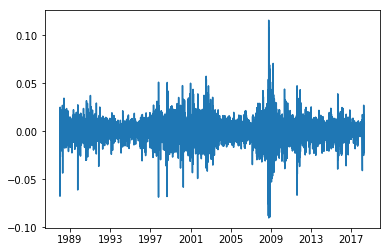

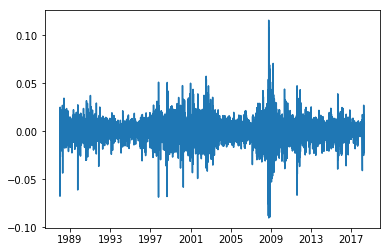

In [41]:
plt.plot(sp_rets)

In [43]:
sp_std = sp_rets.rolling(252).std()
sp_rets = sp_rets.rolling(252).mean()

act_std = active_rets['average'].rolling(252).std()
act_rets = active_rets['average'].rolling(252).mean()

pas_std = passive_rets['average'].rolling(252).std()
pas_rets = passive_rets['average'].rolling(252).mean()

In [ ]:
plt.plot(act_rets)

In [ ]:
plt.plot(sp_rets, pas_rets, act_rets)

In [ ]:
sp = (sp_rets/sp_std).mean()
acta = (act_rets/act_std).mean().values.tolist()
pasa = (pas_rets/pas_std).mean().values.tolist()

In [ ]:
sp_data.reset_index(inplace = True)

In [ ]:
active_rets.reset_index(inplace = True)
sp_rets.reset_index(inplace= True)

In [ ]:
active_excess = sp_rets.merge(active_rets, left_on = 'date', right_on = 'date')

In [ ]:
passive_excess.head(2)

In [ ]:
passive_excess.tail(2)

### Number of Active vs Passive Funds

In [ ]:
active = len(df_passive)
passive = len(df_active)

total = active + passive
act = round(100*(active/total),2)
pas = round(100*(passive/total),2)

### Management fees - Active vs Passive Funds

In [ ]:
avg_active = round(df_active['Management Fee'].mean(),3)
avg_passive = round(df_passive['Management Fee'].mean(),3)


### Expense Ratio - Active vs Passive

In [ ]:
avg_active_exp = round(df_active['Expense Ratio'].mean(),3)
avg_passive_exp = round(df_passive['Expense Ratio'].mean(),3)

# Visualization

In [ ]:
active_mgmt = df_active['Management Fee']
pass_mgmt = df_passive['Management Fee']
active_exp = df_active['Expense Ratio']
pass_exp = df_passive['Expense Ratio']

In [ ]:
df_active.loc[:,'Expense Ratio'] *= 100
df_passive.loc[:,'Expense Ratio'] *= 100

### Distribution of Fund Management Fee's

In [ ]:
plt.hist(active_mgmt, bins = 500, label='active')
plt.hist(pass_mgmt, bins = 500, label='passive')
plt.xlabel('Management Fee')
plt.ylabel('Number of Funds')
plt.legend(loc='upper right')
plt.xlim(0,3)
plt.show()

### Distribution of Fund Expense Ratio's

In [ ]:
plt.hist(active_exp, bins = 700, label='active')
plt.hist(pass_exp, bins = 50, label='passive')
plt.xlabel('Expense Ratio')
plt.ylabel('Number of Funds')
plt.legend(loc='upper right')
plt.xlim(0,7)
plt.show()

# FIX!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
plt.scatter(acta, pasa,  color = ['r', 'g'], marker = '+')
plt.xlabel('Standard Deviation')
plt.ylabel('Return')

# Conclusion

In [ ]:
print('Average management fee for actively managed funds: {}%'.format(avg_active))
print('Average management fee for passively managed funds: {}%'.format(avg_passive))

In [ ]:
print('There are {} ({}%) actively managed mutual funds'.format(active, act))
print('There are {} ({}%) passively managed mutual funds'.format(passive, pas))

In [ ]:
print('Average expense ratio for actively managed funds: {}%'.format(avg_active_exp))
print('Average expense ratio for passively managed funds: {}%'.format(avg_passive_exp))